# Analysis of new new algorithm

In [4]:
from IPython.display import display, HTML
from ipywidgets import interact, interactive
from py2neo import Node, Relationship, Graph
from scipy.linalg import toeplitz
from scipy.stats import binom
from tqdm import tqdm_notebook as tqdm

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pk
import pymania as mn

In [96]:
%matplotlib inline
graph = Graph(host="canopus.cc.gatech.edu",password='1234')
sub_train = [126426, 137431, 144125, 146735, 152427, 153227, 177140, 180533, 186545, 188145]
sub_test  = [206323, 227533, 248238, 360030, 361234, 362034, 368753, 401422, 413934, 453542]
NOS = 5000

run_id_dense = "Constantine_dense_v2"
run_id_sparse = "Constantine_sparse_v2"
run_id_vdense = "Constantine_vdense_v2"
run_id_vsparse = "Constantine_vsparse_v2"
run_id_all = [run_id_vsparse, run_id_sparse, run_id_dense, run_id_vdense]
suffixes = ['vsparse', 'sparse', 'dense', 'vdense']
run_label = {"Constantine_dense_v2":"Dense", "Constantine_sparse_v2":"Sparse", 
             "Constantine_vdense_v2":"Very Dense", "Constantine_vsparse_v2":"Very Sparse"}

all_subjects = sub_train + sub_test
n_train, n_test = len(sub_train), len(sub_test)

In [7]:
def joini(lst):
    return ', '.join(str(x) for x in lst)

# Run Mania on all Subjects

In [8]:
def get_network(subjects, run_type):
    network = mn.create_project('Constantine', run_type)
    for roi in ['L'+str(xx) for xx in range(1,181)]:
        network.add_roi(roi)
    for subject in subjects:
        network.add_subject(subject)
    network.load()
    network.run()
    return network

In [9]:
dense_network = get_network(sub_train, 'dense_temp')
sparse_network = get_network(sub_train, 'sparse_temp')
vdense_network = get_network(sub_train, 'vdense_temp')
vsparse_network = get_network(sub_train, 'vsparse_temp')

In [10]:
network = {'dense':dense_network, 'sparse':sparse_network, 'vdense':vdense_network, 'vsparse':vsparse_network}

# Network Density and it's Consistency across subjects
First, we try to see the total network density over all subjects and the consistency across each subject

In [11]:
query = f"MATCH (n:ROI)-[r:MANIA2]->(m:ROI) WHERE n.name STARTS WITH 'L' AND r.is_connected=TRUE AND "
query += f"r.run_id IN {run_id_all} WITH r.run_id as run_id, COUNT(*) AS connections, COUNT(DISTINCT r.SUBJECT) AS num_sub, AVG(r.threshold2) as mean2 "
query += "RETURN run_id, num_sub, connections*100.0/(32220.0*num_sub) as density, AVG(mean2) as threshold"
densities = graph.run(query).to_data_frame()

In [12]:
density_th = dict()
for index, row in densities.iterrows():
    density_th[row['run_id']] = {'num_sub':row['num_sub'], 'threshold':row['threshold'], 'density':row['density']}

In [13]:
html = '<table><tr><th>Method</th><th># Subjects</th><th>Avg. Threshold</th><th>Density</th></tr>'
for run_id in run_id_all:
    html += f"<tr><td>{run_label[run_id]}</td><td>{density_th[run_id]['num_sub']}</td>"
    html += "<td>%7.2f</td><td>%5.2f%%</td></tr>" % (density_th[run_id]['threshold'], density_th[run_id]['density'])
html += '</table>'
display(HTML(html))

Method,# Subjects,Avg. Threshold,Density
Very Sparse,20,3228.15,3.10%
Sparse,20,516.05,11.72%
Dense,20,44.23,23.82%
Very Dense,20,85.35,27.14%


Here, we take compute the density and the average threshold for the four methods over 20 subjects.

As expected, the density increases from _Very Sparse_ to _Sparse_ to _Dense_ to _Very Dense_ networks.

However, the average threshold for the _Dense_ looks like an anamoly in the sense that it breaks the pattern of increasing average threshold. We should consider the differences between the _Dense_ and _Very Dense_ networks and the links we correct are different between these two networks. So, we should not compare the thresholds directly.

In [14]:
def get_subject_thresholds(run_id, subjects):
    query = f"MATCH (n:ROI)-[r:MANIA2]->(m:ROI) WHERE n.name STARTS WITH 'L' AND r.is_connected=TRUE AND "
    query += f" r.SUBJECT IN {subjects} AND r.run_id='{run_id}'  "
    query += "WITH r.SUBJECT as subject, COUNT(*) AS connections, AVG(r.threshold2) as threshold "
    query += "RETURN subject, connections, connections*100.0/32220.0 as percentage, threshold ORDER BY percentage"
    return graph.run(query).to_data_frame()

In [15]:
dense_thresholds = get_subject_thresholds(run_id_dense, sub_train)
sparse_thresholds = get_subject_thresholds(run_id_sparse, sub_train)
vdense_thresholds = get_subject_thresholds(run_id_vdense, sub_train)
vsparse_thresholds = get_subject_thresholds(run_id_vsparse, sub_train)

In [16]:
threshold1 = dense_thresholds.merge(sparse_thresholds, how='inner', on=['subject'], suffixes=('_dense', '_sparse'))
threshold2 = vdense_thresholds.merge(vsparse_thresholds, how='inner', on=['subject'], suffixes=('_vdense', '_vsparse'))
thresholds = threshold1.merge(threshold2, how='inner', on=['subject'])

In [17]:
html = '<table><tr><th rowspan="2" align="center" >Subject</th><th colspan="3">Very Sparse</th>'
html += '<th colspan="3">Sparse</th><th colspan="3">Dense</th><th colspan="3">Very Dense</th></tr><tr>'
for i in range(4):
    html += '<th>Density</th><th>Threshold</th><th>NAR</th>'
html += '</tr>'
for index, row in thresholds.iterrows():
    html += "<tr><td>%d</td>" % row['subject']
    for suffix in suffixes:
        html += "<td>%5.2f%%</td><td>%d</td>" % (row['percentage_'+suffix], row['threshold_'+suffix])
        html += '<td>%5.3f</td>' % mn.utils.NAR(network[suffix](row['subject']).mania2_network)
    html += "</tr>"
display(HTML(html))

Even when considering each subject separately, we see that the trend mentioned above continues.

However, we should note that density (and other metrics) of the four algorithms does not vary similarly. For example, the density for subject 144125 is the least among all the subjects for the _Very Sparse_ algorithm. However, it's not the lowest for the other algorithms.

# Consistency of Adjacent Nodes

In [18]:
query = f"MATCH (n:ROI)-[r:MANIA2]->(m:ROI) WHERE n.name STARTS WITH 'L' AND r.border>0 "
query += f"AND r.SUBJECT IN {sub_train} AND r.run_id IN {run_id_all} RETURN r.run_id AS run_id, "
query += "r.SUBJECT as subject, r.is_connected AS is_connected, COUNT(*) AS count"
adjacency_frame = graph.run(query).to_data_frame()

In [19]:
adjacency_counts = dict()
for index, row in adjacency_frame.iterrows():
    subject, run_id = row['subject'], row['run_id']
    if subject not in adjacency_counts:
        adjacency_counts[subject] = dict()
    if run_id not in adjacency_counts[subject]:
        adjacency_counts[subject][run_id] = {True:0, False:0, 'Total':0}
    adjacency_counts[subject][run_id][row['is_connected']] += row['count']

In [20]:
html = '<table><tr><th rowspan="2" align="center" >Subject</th><th colspan="2">Very Sparse</th>'
html += '<th colspan="2">Sparse</th><th colspan="2">Dense</th><th colspan="2">Very Dense</th></tr><tr>'
for i in range(4):
    html += '<th>% of Adjancent Nodes</th><th>% Adj. Connected</th>'
html += '</tr>'
for subject, values in adjacency_counts.items():
    html += f'<tr><td>{subject}</td>'
    for suffix in suffixes:
        counts = values[f'Constantine_{suffix}_v2']
        pct_adj = (counts[True] + counts[False]) / 322.20
        pct_con = counts[True] * 100. / (counts[True] + counts[False])
        html += '<td>%5.2f%%</td><td>%5.2f%%</td>' % (pct_adj, pct_con)
    html += '</tr>'
html += '</table>'
display(HTML(html))

In [21]:
query = f"MATCH (n:ROI)-[r:MANIA2]->(m:ROI) WHERE n.name STARTS WITH 'L' AND r.border>0 "
query += f"AND r.SUBJECT IN {sub_train} AND r.run_id IN {run_id_all} "
query += "WITH r.run_id AS run_id, n.name AS source, m.name AS target, COUNT(*) AS num_subjects "
query += " RETURN run_id, num_subjects, COUNT(*) AS num_links"
adjacency_count = graph.run(query).to_data_frame()

In [22]:
adjacency_counts = dict()
for index, row in adjacency_count.iterrows():
    run_id = str(row['run_id'].split('_')[1])
    if run_id not in adjacency_counts:
        adjacency_counts[run_id] = np.zeros(len(sub_train)+1, dtype=int)
    adjacency_counts[run_id][row['num_subjects']] = row['num_links']

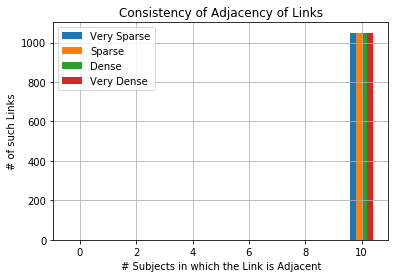

In [23]:
plt.figure()
x_axis = np.arange(0, len(sub_train)+1)
plt.bar(x_axis-0.3, adjacency_counts['vsparse'], width=0.2, label='Very Sparse')
plt.bar(x_axis-0.1, adjacency_counts['sparse'], width=0.2, label='Sparse')
plt.bar(x_axis+0.1, adjacency_counts['dense'], width=0.2, label='Dense')
plt.bar(x_axis+0.3, adjacency_counts['vdense'], width=0.2, label='Very Dense')
plt.legend()
plt.grid()
plt.title('Consistency of Adjacency of Links')
plt.xlabel('# Subjects in which the Link is Adjacent')
plt.ylabel('# of such Links')
plt.show()

In [24]:
query = f"MATCH (n:ROI)-[r:MANIA2]->(m:ROI) WHERE n.name STARTS WITH 'L' AND r.correction_type='Adjacent' "
query += f"AND r.SUBJECT IN {sub_train} AND r.run_id IN {run_id_all} AND r.is_connected=TRUE "
query += "WITH r.run_id AS run_id, n.name AS source, m.name AS target, COUNT(*) AS num_subjects "
query += " RETURN run_id, num_subjects, COUNT(*) AS num_links"
adj_connected_count = graph.run(query).to_data_frame()

In [25]:
adj_connected_counts = dict()
for index, row in adj_connected_count.iterrows():
    run_id = str(row['run_id'].split('_')[1])
    if run_id not in adj_connected_counts:
        adj_connected_counts[run_id] = np.zeros(len(sub_train)+1, dtype=int)
    adj_connected_counts[run_id][row['num_subjects']] = row['num_links']

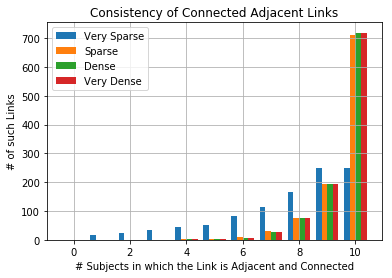

In [26]:
plt.figure()
x_axis = np.arange(0, len(sub_train)+1)
plt.bar(x_axis-0.3, adj_connected_counts['vsparse'], width=0.2, label='Very Sparse')
plt.bar(x_axis-0.1, adj_connected_counts['sparse'], width=0.2, label='Sparse')
plt.bar(x_axis+0.1, adj_connected_counts['dense'], width=0.2, label='Dense')
plt.bar(x_axis+0.3, adj_connected_counts['vdense'], width=0.2, label='Very Dense')
plt.legend()
plt.grid()
plt.title('Consistency of Connected Adjacent Links')
plt.xlabel('# Subjects in which the Link is Adjacent and Connected')
plt.ylabel('# of such Links')
plt.show()

# Mania Plots

In [27]:
plot_manias_cache = dict()

In [29]:
def plot_manias(subject):
    subject = int(subject)
    if subject not in plot_manias_cache:
        dense_sub, sparse_sub = dense_network(subject), sparse_network(subject)
        vdense_sub, vsparse_sub = vdense_network(subject), vsparse_network(subject)
        _,den_1,nar_1,t_1 = mn.utils.networks.mania_on_mat(dense_sub.matrix1)
        _,den_d,nar_d,t_d = mn.utils.networks.mania_on_mat(dense_sub.matrix2)
        _,den_s,nar_s,t_s = mn.utils.networks.mania_on_mat(sparse_sub.matrix2)
        _,den_vd,nar_vd,t_vd = mn.utils.networks.mania_on_mat(vdense_sub.matrix2)
        _,den_vs,nar_vs,t_vs = mn.utils.networks.mania_on_mat(vsparse_sub.matrix2)
        threshold_1 = dense_sub.threshold1
        threshold_d, threshold_vd = dense_sub.threshold2, vdense_sub.threshold2
        threshold_s, threshold_vs = sparse_sub.threshold2, vsparse_sub.threshold2
        idx_1, idx_d, idx_s = np.argmin(nar_1), np.argmin(nar_d), np.argmin(nar_s)
        idx_vd, idx_vs = np.argmin(nar_vd), np.argmin(nar_vs)
        density_1, density_d, density_s = den_1[idx_1], den_d[idx_d], den_s[idx_s]
        density_vd, density_vs = den_vd[idx_vd], den_vs[idx_vs]
        nar_value_1, nar_value_d, nar_value_s = nar_1[idx_1], nar_d[idx_d], nar_s[idx_s]
        nar_value_vd, nar_value_vs = nar_vd[idx_vd], nar_vs[idx_vs]
        d = dict()
        d['den_1'], d['den_d'], d['den_s'], d['den_vd'], d['den_vs'] = den_1, den_d, den_s, den_vd, den_vs
        d['nar_1'], d['nar_d'], d['nar_s'], d['nar_vd'], d['nar_vs'] = nar_1, nar_d, nar_s, nar_vd, nar_vs
        d['density_1'], d['density_d'], d['density_s'], d['density_vd'], d['density_vs'] = density_1, density_d, density_s, density_vd, density_vs
        d['nar_value_1'], d['nar_value_d'], d['nar_value_s'], d['nar_value_vd'], d['nar_value_vs'] = nar_value_1, nar_value_d, nar_value_s, nar_value_vd, nar_value_vs
        d['t_1'], d['t_d'], d['t_s'], d['t_vd'], d['t_vs'] = t_1, t_d, t_s, t_vd, t_vs
        d['threshold_1'], d['threshold_d'], d['threshold_s'], d['threshold_vd'], d['threshold_vs'] = threshold_1, threshold_d, threshold_s, threshold_vd, threshold_vs
        plot_manias_cache[subject] = d
    else:
        d = plot_manias_cache[subject]
        den_1, den_d, den_s, den_vd, den_vs = d['den_1'], d['den_d'], d['den_s'], d['den_vd'], d['den_vs']
        nar_1, nar_d, nar_s, nar_vd, nar_vs = d['nar_1'], d['nar_d'], d['nar_s'], d['nar_vd'], d['nar_vs']
        density_1, density_d, density_s, density_vd, density_vs = d['density_1'], d['density_d'], d['density_s'], d['density_vd'], d['density_vs']
        nar_value_1, nar_value_d, nar_value_s, nar_value_vd, nar_value_vs = d['nar_value_1'], d['nar_value_d'], d['nar_value_s'], d['nar_value_vd'], d['nar_value_vs']
        t_1, t_d, t_s, t_vd, t_vs = d['t_1'], d['t_d'], d['t_s'], d['t_vd'], d['t_vs']
        threshold_1, threshold_d, threshold_s, threshold_vd, threshold_vs = d['threshold_1'], d['threshold_d'], d['threshold_s'], d['threshold_vd'], d['threshold_vs']
    
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,6))
    ax[0].plot(den_1,nar_1,'b-',lw=2,label='MANIA 1')
    ax[0].plot(den_vs,nar_vs,'c-',lw=2,label='Very Sparse')
    ax[0].plot(den_s,nar_s,'g-',lw=2,label='Sparse')
    ax[0].plot(den_d,nar_d,'r-',lw=2,label='Dense')
    ax[0].plot(den_vd,nar_vd,'m-',lw=2,label='Very Dense')
    ax[0].axvline(density_1, 0, 1, color='b', linestyle='dashed', lw=1)
    ax[0].axvline(density_d, 0, 1, color='r', linestyle='dashed', lw=1)
    ax[0].axvline(density_s, 0, 1, color='g', linestyle='dashed', lw=1)
    ax[0].axvline(density_vd, 0, 1, color='m', linestyle='dashed', lw=1)
    ax[0].axvline(density_vs, 0, 1, color='c', linestyle='dashed', lw=1)
    ax[0].axhline(nar_value_1, 0, 1, color='b', linestyle='dashed', lw=1)
    ax[0].axhline(nar_value_d, 0, 1, color='r', linestyle='dashed', lw=1)
    ax[0].axhline(nar_value_s, 0, 1, color='g', linestyle='dashed', lw=1)
    ax[0].axhline(nar_value_vd, 0, 1, color='m', linestyle='dashed', lw=1)
    ax[0].axhline(nar_value_vs, 0, 1, color='c', linestyle='dashed', lw=1)
    ax[0].set_xlabel('density')
    ax[0].set_ylabel('NAR')
    ax[1].plot(t_1,den_1,'b-',lw=2,label='MANIA 1')
    ax[1].plot(t_vs,den_vs,'c-',lw=2,label='Very Sparse')
    ax[1].plot(t_s,den_s,'g-',lw=2,label='Sparse')
    ax[1].plot(t_d,den_d,'r-',lw=2,label='Dense')
    ax[1].plot(t_vd,den_vd,'m-',lw=2,label='Very Dense')
    ax[1].set_xlabel('Threshold')
    ax[1].set_ylabel('Density')
    ax[1].axvline(threshold_1, color='b', linestyle='dashed', lw=1)
    ax[1].axvline(threshold_d, color='r', linestyle='dashed', lw=1)
    ax[1].axvline(threshold_s, color='g', linestyle='dashed', lw=1)
    ax[1].axvline(threshold_vd, color='m', linestyle='dashed', lw=1)
    ax[1].axvline(threshold_vs, color='c', linestyle='dashed', lw=1)
    ax[1].axhline(density_1, 0, 1, color='b', linestyle='dashed', lw=1)
    ax[1].axhline(density_d, 0, 1, color='r', linestyle='dashed', lw=1)
    ax[1].axhline(density_s, 0, 1, color='g', linestyle='dashed', lw=1)
    ax[1].axhline(density_vd, 0, 1, color='m', linestyle='dashed', lw=1)
    ax[1].axhline(density_vs, 0, 1, color='c', linestyle='dashed', lw=1)
    plt.suptitle(f'Subject: {subject}')
    plt.legend()
    plt.show()

In [31]:
interact(plot_manias, subject=[str(x) for x in sub_train])

interactive(children=(Dropdown(description='subject', options=('126426', '137431', '144125', '146735', '152427…

<function __main__.plot_manias(subject)>

From the plots of density, NAR and threshold for the subjects can be seen.

From the Density v/s NAR plot, we see that the plots for _Very Sparse_ and _Dense_ networks does not have a U-shaped curve as seen in MANIA1 and the other methods. We can see a distinct W shaped curve for these two algorithms. This is pretty consistent across all subjects and is clearly seen in the subject below. I'm not sure what causes this.

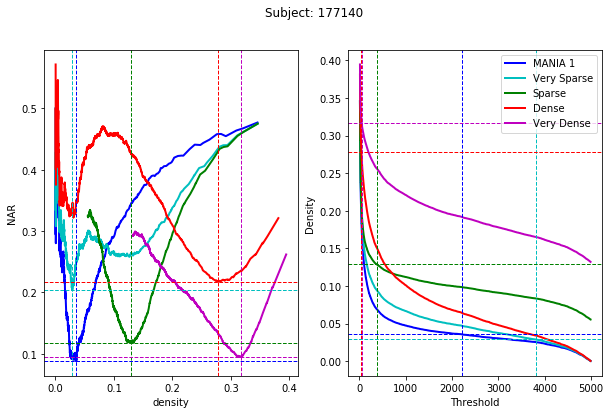

In [32]:
plot_manias(177140)

# Correction Types

In [33]:
def get_type(corr_type, reg_type, sparse):
    if corr_type == 'Null':
        return 'Null'
    if corr_type == 'Adjacent':
        return 'Adjacent'
    if corr_type in ['Bad regressor', 'No Envelope No regress']:
        return 'No Correction'
    if corr_type == 'Regress' and reg_type == 'independent':
        return 'Independent'
    if sparse:
        if reg_type in ['direction1', 'direction2', 'poolAll', 'poolEnvelopes']:
            return 'No Correction'
    else:
        if reg_type == 'direction1' or reg_type == 'direction2':
            return 'one direction'
        if reg_type == 'poolAll' or reg_type == 'poolEnvelopes':
            return reg_type
    if corr_type == 'No Correction':
        return 'No Correction'
    print('Error while evaluating: ', corr_type, reg_type)

In [34]:
def get_filter(algo_type):
    assert (algo_type in types)
    if algo_type in ['Null', 'Adjacent'] :
        return f"r.correction_type='{algo_type}'"
    if algo_type == 'No Correction':
        return "r.correction_type IN ['Bad regressor', 'No Envelope No regress', 'No Correction']"
    if algo_type == 'Independent':
        return "(r.correction_type='Regress' AND r.regressor_type='independent')"
    if algo_type == 'one direction':
        return "(r.correction_type IN ['No Envelope but regress', 'Regress'] AND r.regressor_type IN ['direction1', 'direction2'])"
    if algo_type == 'poolAll':
        return "(r.correction_type IN ['No Envelope but regress', 'Regress'] AND r.regressor_type = 'poolAll')"
    string = "("
    first = True
    for (corr_type, reg_type) in types[algo_type]:
        if not first:
            string += "OR "
        else:
            first = False
        string += f"(r.correction_type='{corr_type}' AND r.regressor_type='{reg_type}') "
    string += ")"
    return string

In [35]:
types = {'Null':set(), 'Adjacent':set(), 'No Correction':set(), 'Independent':set(), 'one direction':set(), 'poolAll':set()}
def get_counts_by_type(run_id, subjects):
    query = f"MATCH (n:ROI)-[r:MANIA2]->(m:ROI) WHERE n.name STARTS WITH 'L' AND r.SUBJECT IN [{joini(subjects)}] "
    query += f"AND r.is_connected=TRUE AND r.run_id='{run_id}' "
    query += "RETURN r.correction_type AS correction_type, r.regressor_type AS regressor_type, COUNT(*) AS counts"
    counts_true = graph.run(query).to_ndarray()
    query = f"MATCH (n:ROI)-[r:MANIA2]->(m:ROI) WHERE n.name STARTS WITH 'L' AND r.SUBJECT IN [{joini(subjects)}] "
    query += f"AND r.is_connected=FALSE AND r.run_id='{run_id}' "
    query += f"RETURN r.correction_type AS correction_type, r.regressor_type AS regressor_type, COUNT(*) AS counts"
    counts_false = graph.run(query).to_ndarray()
    counts = dict()
    for row in counts_true:
        algo_type = get_type(row[0], row[1], 'sparse' in run_id)
        types[algo_type].add((row[0], row[1]))
        if algo_type not in counts:
            counts[algo_type] = {True:0, False:0}
        counts[algo_type][True] += int(row[2])
    for row in counts_false:
        algo_type = get_type(row[0], row[1], 'sparse' in run_id)
        types[algo_type].add((row[0], row[1]))
        if algo_type not in counts:
            counts[algo_type] = {True:0, False:0}
        counts[algo_type][False] += int(row[2])
    for algo_type in counts:
        counts[algo_type]['total'] = counts[algo_type][True] + counts[algo_type][False]
    total = 0
    for algo_type in counts:
        total += counts[algo_type]['total']
    assert total == len(subjects)*32220
    for algo_type in counts:
        counts[algo_type]['fraction'] = counts[algo_type]['total']/float(total)
        counts_all = counts[algo_type][True] + counts[algo_type][False]
        counts[algo_type]['pct_connected'] = counts[algo_type][True]*100./counts_all
    return counts

In [36]:
by_type_sparse = get_counts_by_type(run_id_sparse, sub_train)
by_type_vdense = get_counts_by_type(run_id_vdense, sub_train)
by_type_dense = get_counts_by_type(run_id_dense, sub_train)
by_type_vsparse = get_counts_by_type(run_id_vsparse, sub_train)

In [37]:
html = '<table><tr><th rowspan="2">Type</th><th colspan="2">Very Sparse</th><th colspan="2">Sparse</th>'
html += '<th colspan="2">Dense</th><th colspan="2">Very Dense</th></tr><tr>'
for i in range(4):
    html += '<th>Fraction of Total</th><th>% Connected</th>'
html += '</tr>'
for algo_type in ['Adjacent', 'Independent', 'poolAll', 'one direction', 'No Correction', 'Null']:
    if algo_type in by_type_dense:
        dense = by_type_dense[algo_type]
    else:
        dense = {'fraction':0., 'pct_connected':0.}
    if algo_type in by_type_sparse:
        sparse = by_type_sparse[algo_type]
    else:
        sparse = {'fraction':0., 'pct_connected':0.}
    if algo_type in by_type_vdense:
        vdense = by_type_vdense[algo_type]
    else:
        vdense = {'fraction':0., 'pct_connected':0.}
    if algo_type in by_type_vsparse:
        vsparse = by_type_vsparse[algo_type]
    else:
        vsparse = {'fraction':0., 'pct_connected':0.}
    html += '<tr><td>%s</td>' % algo_type
    html += '<td>%5.2f%%</td><td>%5.2f%%</td>' % (vsparse['fraction']*100, vsparse['pct_connected'])
    html += '<td>%5.2f%%</td><td>%5.2f%%</td>' % (sparse['fraction']*100, sparse['pct_connected'])
    html += '<td>%5.2f%%</td><td>%5.2f%%</td>' % (dense['fraction']*100, dense['pct_connected'])
    html += '<td>%5.2f%%</td><td>%5.2f%%</td></tr>' % (vdense['fraction']*100, vdense['pct_connected'])
html += '</table>'
display(HTML(html))

# Sample Links from Different types

In [136]:
def get_sample_links(subjects, run_id, algo_type, num_links = 10):
    query = f"MATCH (n:ROI)-[r:MANIA2]->(m:ROI) WHERE n.name STARTS WITH 'L' AND r.run_id='{run_id}' "
    query += f"AND r.SUBJECT IN {subjects} AND {get_filter(algo_type)} "
    query += "WITH n.name AS source, m.name AS target, r.SUBJECT AS subject "
    query += f"RETURN subject, source, target LIMIT {num_links}"
    return graph.run(query).to_data_frame()

links_vdense = dict()
num_links = 1000
for algo_type in types:
    links_vdense[algo_type] = get_sample_links(sub_train, run_id_vdense, algo_type, num_links)

In [164]:
def plot_st(st, thresholds, ax=None):
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))
    ax.set_ylabel(r'$T_{log}$')
    ax.set_xlabel('Distance (mm)')
    ax.set_title(f'{st.roi1}->{st.roi2}-({st.get_type()})')
    if st.isNull():
        ax.set_facecolor('#000000')
        ax.text(0.05,.9,f'SUB:{st.subject}',color="white")
        return
    ax.text(0.05,-1,f'SUB:{st.subject}',color="black")
    ax.plot(st.data[:,0],st.data[:,1],'b*')
    if(len(st.envelopes)>0):
        ax.plot(st.data[st.envelopes,0],st.data[st.envelopes,1],'gs',ms=6,label="Envelope points")
        if st.regressor:
            x = st.data[st.envelopes,0]
            z = list(map(st.regressor.predict,x))
            ax.plot(x,z,'k',lw=2,label='Regressor')
    """if self.isConnected():
        ax.set_facecolor((0/255,255/255,0/255,.2))
    else:
        ax.set_facecolor((80/255,80/255,80/255,.2))"""

    ax.set_ylim(top=0)
    ax.set_xlim(left=-5)
    ax.axvline(0,lw=0.5,color='black')
    ax.axhline(np.log(thresholds['mania1']/NOS),lw=2,color='b',label='MANIA1 threshold')
    ax.axhline(np.log(thresholds['vsparse']/NOS),lw=2,color='c',label='Very Sparse threshold')
    ax.axhline(np.log(thresholds['sparse']/NOS),lw=2,color='g',label='Sparse threshold')
    ax.axhline(np.log(thresholds['dense']/NOS),lw=2,color='r',label='Dense threshold')
    ax.axhline(np.log(thresholds['vdense']/NOS),lw=2,color='m',label='Very Dense threshold')
    ax.scatter([0], st.weight, marker='v', lw=2, label='Weight')
    ax.scatter([0], st.corrected_weight, marker='^', lw=2, label='Corrected Weight')
    # ax.legend()
    return ax

def plot_pair(pair_vs, pair_s, pair_d, pair_vd, thresholds, ax = None):
    if ax is not None:
        assert len(ax)==2, "You must provide two axis for pairST plot"
    else:
        fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,7), sharex=True, sharey=True)
    plot_st(pair_vd.st1, thresholds, ax[0])
    plot_st(pair_vd.st2, thresholds, ax[1])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

def getWeight(network, sst, mania2=True):
    subject, source, target = sst
    if mania2:
        weight = network(subject)(source, target, pair=False).corrected_weight
    else:
        weight = network(subject)(source, target, pair=False).weight
    return int(np.round(np.exp(weight)*NOS))

In [165]:
def plot_link(subject, source, target):
    thresholds = {'vsparse':vsparse_network(subject).threshold2,
                  'sparse':sparse_network(subject).threshold2,
                  'dense':dense_network(subject).threshold2,
                  'vdense':vdense_network(subject).threshold2,
                  'mania1':vsparse_network(subject).threshold1
                 }
    pair_vs = vsparse_network(subject)(source, target, pair=True)
    pair_s = sparse_network(subject)(source, target, pair=True)
    pair_d = dense_network(subject)(source, target, pair=True)
    pair_vd = vdense_network(subject)(source, target, pair=True)
    sst = (subject, source, target)
    rsst = (subject, target, source)
    html = '<table><tr><th></th><th>Mania 1</th><th>Very Sparse</th><th>Sparse</th><th>Dense</th><th>Very Dense</th></tr>'
    html += '<tr><th>Threshold</th>'
    for k in ['mania1', 'vsparse', 'sparse', 'dense', 'vdense']:
        html += f'<td>{thresholds[k]}</td>'
    html += '</tr><tr><th>Forward Weight</th>'
    html += f'<td>{getWeight(vdense_network, sst, False)}</td>'
    html += f'<td>{getWeight(vsparse_network, sst)}</td><td>{getWeight(sparse_network, sst)}</td>'
    html += f'<td>{getWeight(dense_network, sst)}</td><td>{getWeight(vdense_network, sst)}</td></tr>'
    html += f'<tr><th>Is Connected</th><td>{vsparse_network(subject).is_connected(source, target, False)}</td>'
    html += f'<td>{vsparse_network(subject).is_connected(source, target)}</td>'
    html += f'<td>{sparse_network(subject).is_connected(source, target)}</td>'
    html += f'<td>{dense_network(subject).is_connected(source, target)}</td>'
    html += f'<td>{vdense_network(subject).is_connected(source, target)}</td></tr>'
    html += '</tr>'
    html += f'<tr><th>Is Reverse Connected</th><td>{vsparse_network(subject).is_connected(source, target, False)}</td>'    
    html += f'<td>{vsparse_network(subject).is_connected(source, target)}</td>'
    html += f'<td>{sparse_network(subject).is_connected(source, target)}</td>'
    html += f'<td>{dense_network(subject).is_connected(source, target)}</td>'
    html += f'<td>{vdense_network(subject).is_connected(source, target)}</td></tr>'
    html += '<tr><th>Reverse Weight</th>'
    html += f'<td>{getWeight(vdense_network, rsst, False)}</td>'
    html += f'<td>{getWeight(vsparse_network, rsst)}</td><td>{getWeight(sparse_network, rsst)}</td>'
    html += f'<td>{getWeight(dense_network, rsst)}</td><td>{getWeight(vdense_network, rsst)}</td></tr>'
    html += '</table>'
    display(HTML(html))
    plot_pair(pair_vs, pair_s, pair_d, pair_vd, thresholds)

,Mania 1,Very Sparse,Sparse,Dense,Very Dense
Threshold,3333,3334,357,48,66
Forward Weight,1,1,1,1,1
Is Connected,False,False,False,False,False
Is Reverse Connected,False,False,False,False,False
Reverse Weight,7,7,7,7,7


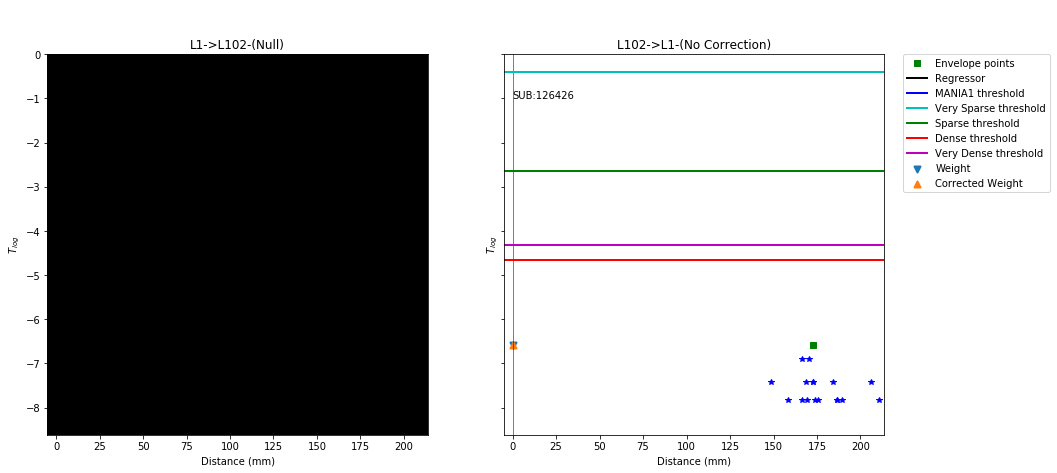

,Mania 1,Very Sparse,Sparse,Dense,Very Dense
Threshold,3333,3334,357,48,66
Forward Weight,1,1,1,1,1
Is Connected,False,False,False,False,False
Is Reverse Connected,False,False,False,False,False
Reverse Weight,1,1,1,1,1


No handles with labels found to put in legend.


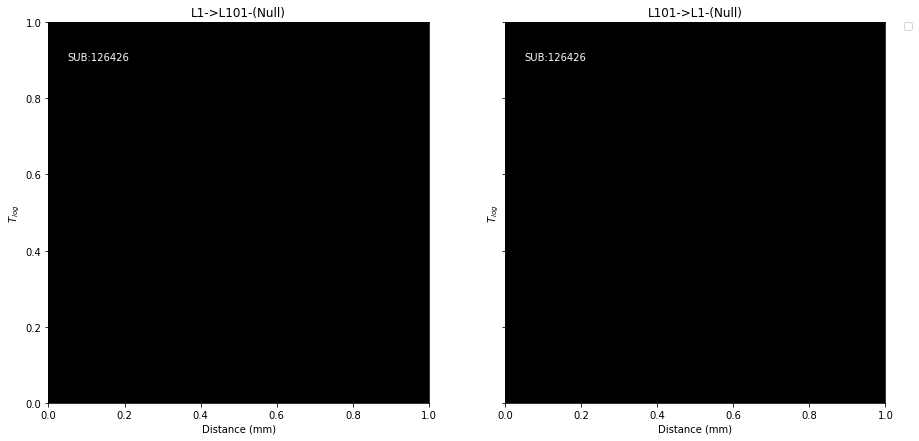

,Mania 1,Very Sparse,Sparse,Dense,Very Dense
Threshold,2582,3849,477,37,91
Forward Weight,3987,3987,3987,3987,3987
Is Connected,True,True,True,True,True
Is Reverse Connected,True,True,True,True,True
Reverse Weight,3885,3885,3885,3885,3885


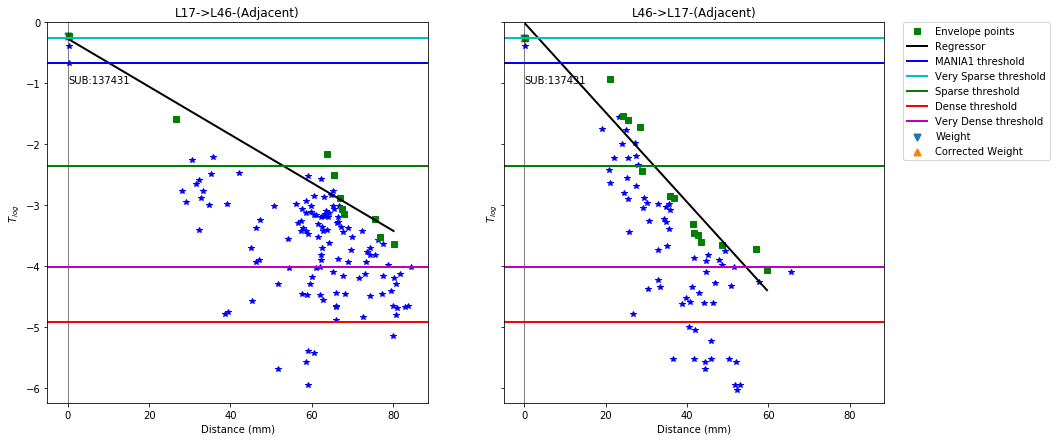

,Mania 1,Very Sparse,Sparse,Dense,Very Dense
Threshold,2201,4596,413,38,60
Forward Weight,4483,4483,4483,4483,4483
Is Connected,True,False,True,True,True
Is Reverse Connected,True,False,True,True,True
Reverse Weight,4718,4718,4718,4718,4718


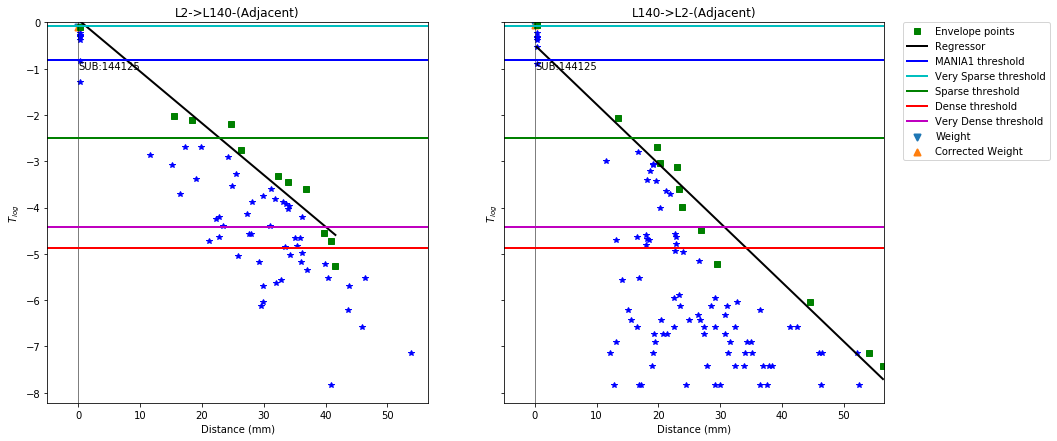

,Mania 1,Very Sparse,Sparse,Dense,Very Dense
Threshold,2498,3274,481,52,116
Forward Weight,7,7,7,7,7
Is Connected,False,False,False,False,False
Is Reverse Connected,False,False,False,False,False
Reverse Weight,19,19,19,19,19


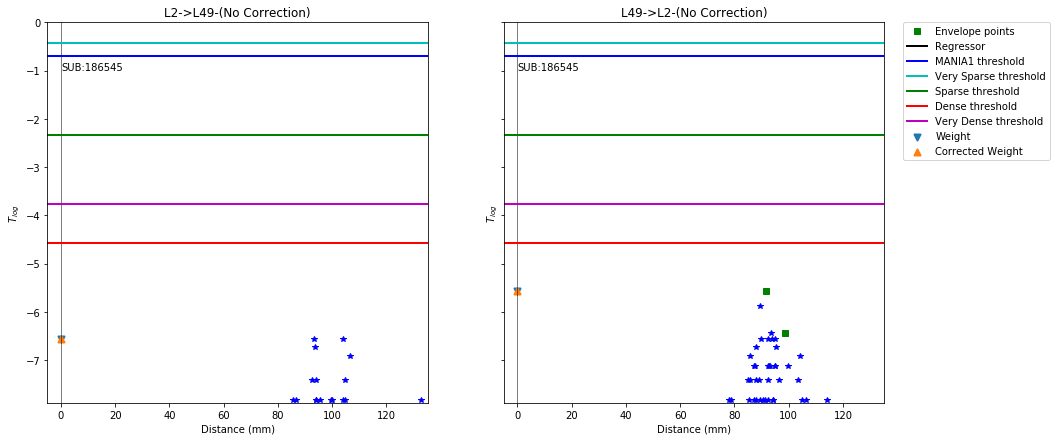

,Mania 1,Very Sparse,Sparse,Dense,Very Dense
Threshold,2793,3062,497,33,52
Forward Weight,21,21,21,21,21
Is Connected,False,False,False,False,False
Is Reverse Connected,False,False,False,False,False
Reverse Weight,3,3,3,3,3


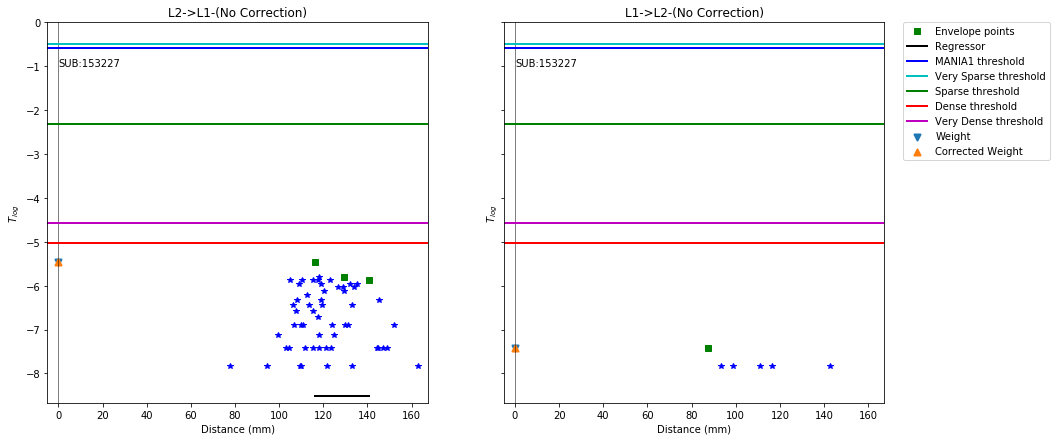

,Mania 1,Very Sparse,Sparse,Dense,Very Dense
Threshold,2131,3191,684,46,60
Forward Weight,88,1276394,1276394,1276394,1276394
Is Connected,False,False,True,True,True
Is Reverse Connected,False,False,True,True,True
Reverse Weight,480,78366006,78366006,78366006,78366006


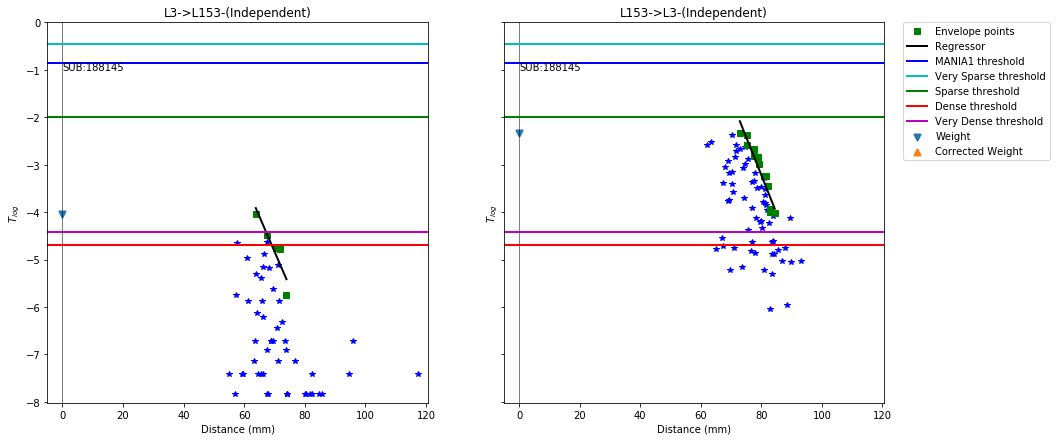

,Mania 1,Very Sparse,Sparse,Dense,Very Dense
Threshold,2582,3849,477,37,91
Forward Weight,277,19893,19893,19893,19893
Is Connected,False,False,True,True,True
Is Reverse Connected,False,False,True,True,True
Reverse Weight,115,8934,8934,8934,8934


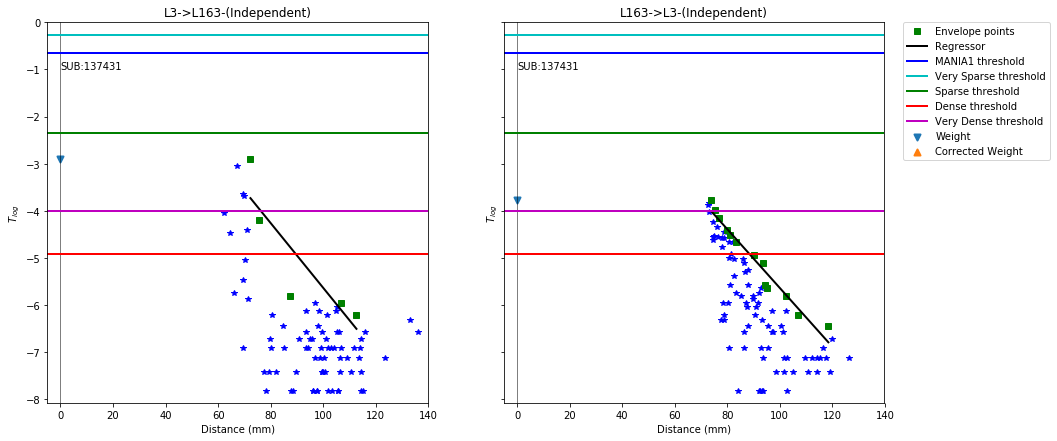

,Mania 1,Very Sparse,Sparse,Dense,Very Dense
Threshold,2793,3062,497,33,52
Forward Weight,151,151,151,136704,136704
Is Connected,False,False,False,True,True
Is Reverse Connected,False,False,False,True,True
Reverse Weight,17,17,17,44204,44204


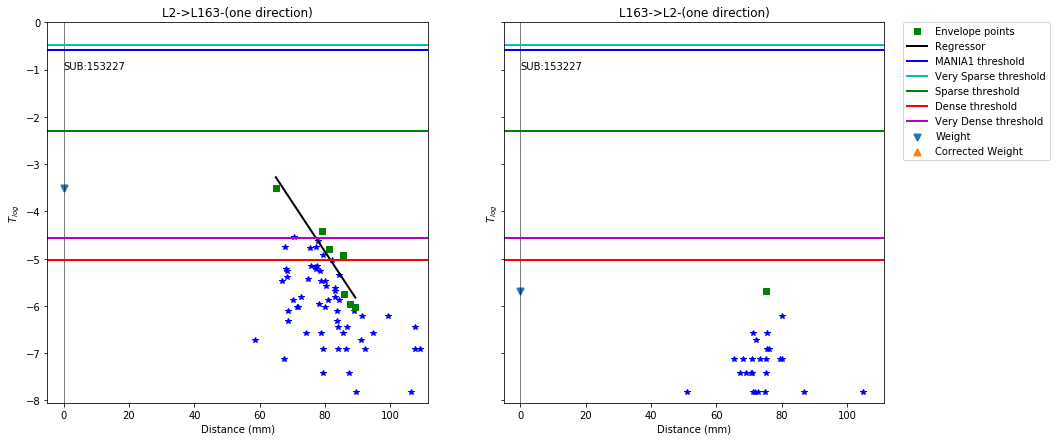

,Mania 1,Very Sparse,Sparse,Dense,Very Dense
Threshold,2169,2887,317,45,134
Forward Weight,10,10,10,49,49
Is Connected,False,False,False,True,False
Is Reverse Connected,False,False,False,True,False
Reverse Weight,34,34,34,212,212


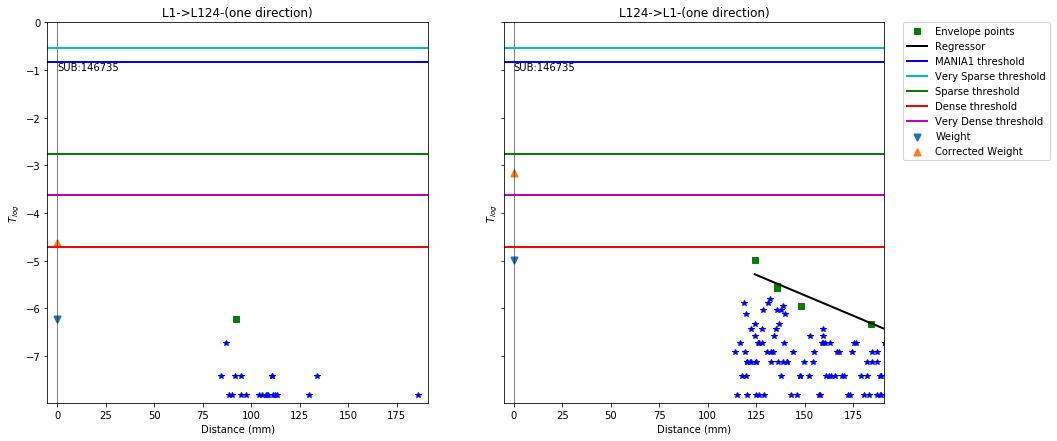

,Mania 1,Very Sparse,Sparse,Dense,Very Dense
Threshold,2498,3274,481,52,116
Forward Weight,219,219,219,3273492,3273492
Is Connected,False,False,False,True,True
Is Reverse Connected,False,False,False,True,True
Reverse Weight,741,741,741,3489664,3489664


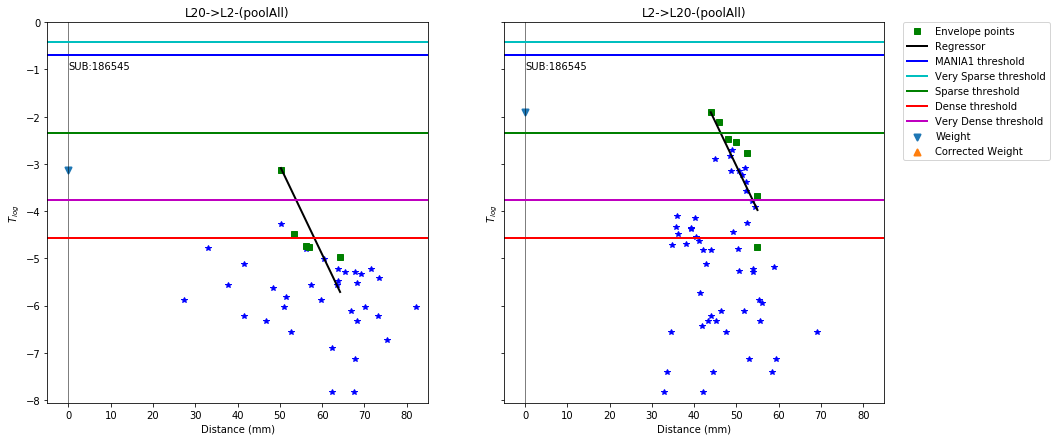

,Mania 1,Very Sparse,Sparse,Dense,Very Dense
Threshold,3333,3334,357,48,66
Forward Weight,12,12,12,1892,1892
Is Connected,False,False,False,True,True
Is Reverse Connected,False,False,False,True,True
Reverse Weight,10,10,10,1916,1916


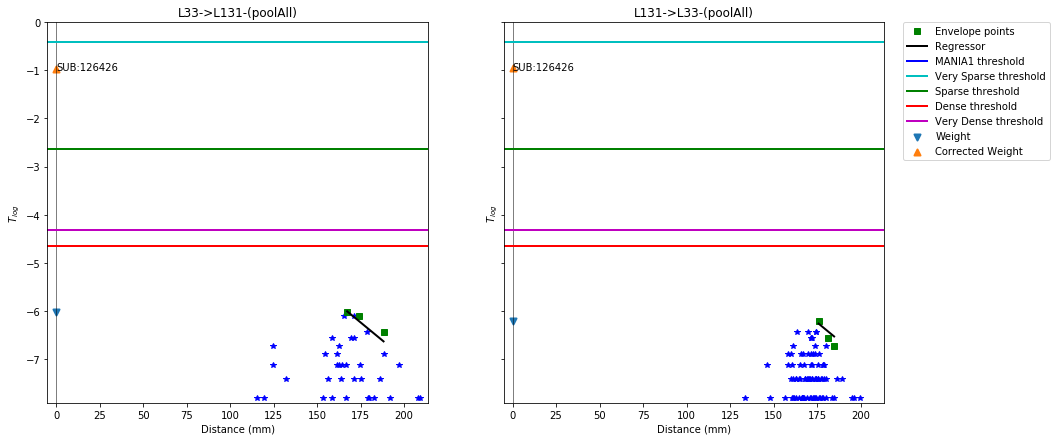

In [168]:
num_links = 2
for alg_type in links_vdense:
    display(HTML(f'<h2>{alg_type}</h2>'))
    rows = np.random.randint(len(links_vdense[alg_type]), size=num_links)
    for idx, row in links_vdense[alg_type].iloc[rows,:].iterrows():
        plot_link(row['subject'], row['source'], row['target'])